<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/projections1-colab-2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Map Projections (Halloween Edition)

<img width=555px src="https://github.com/gisalgs/notebooks/blob/main/figures/halloween-hall-of-fame.png?raw=1"/>

The goal of a map projection is to transform points in a spherical coordinate system onto a two dimensional Cartesian coordinate system. In other words, points on earth surface that are measured in longitude ($\lambda$) and latitude ($\varphi$) pairs become points on a two dimensional plane measured as horizontal ($x$) and vertical ($y$) coordinates. We can imagine there are functions that takes in the longitude and latitude of a point and returns the X and Y coordinates:

$x = f(\lambda, \varphi)$  
$y = f(\lambda, \varphi)$

A straightforward transformation from a mathematical perspective is the special case of the **equirectangular** projection that basically does not do anything other than just use the longitude as the X coordinate, and latitude as Y:

$x = \lambda$  
$y = \varphi$

## Data preparation

To see how any projection actually looks like, we will need the appropriate data sets to begin with. Specifically we need two kinds of data here, the world coast lines and the graticule:

* The world coast lines from Natural Earth, in two formats:
    * A shapefile that is compressed as a tar.gz file at the [Github site](https://github.com/gisalgs/data/blob/master/ne_110m_coastline.tar.gz) (need to uncompress it after downloading).
    * A GeoJSON file at the [Github site](https://github.com/gisalgs/data/blob/master/ne_110m_coastline.geojson). Click on the Raw button to save the file or directly download it at https://raw.githubusercontent.com/gisalgs/data/master/ne_110m_coastline.geojson.
    * Both file formats can be useful on local computers. However, the GeoJSON is also suitable for online notebooks and can be used without being downloaded to local computers as well. This is also a place to re-enforce the difference between the two formats and appreciate why GeoJSON has picked so much popularity lately. Clicking on [this link](https://github.com/gisalgs/data/blob/master/ne_110m_coastline.geojson) allows us to see immediately rendering of the spatial data in the GeoJSON file, which is made possible by a lot of reasons but first reason being everything in the spatial data is encoded in ONE place/file and in plain text. This enables the file to be read and processed easily in different programming languages. [Here](https://github.com/gisalgs/data/blob/master/uscnty48area.geojson) is another example of GeoJSON using the counties data. But shapefile, unfortunately, is not designed in this way, which is understandable given how old this one is, because it has multiples file encoded in binary code that must be specially decoded.
* The graticule is a geojson file that can be downloaded at https://raw.githubusercontent.com/gisalgs/data/refs/heads/master/graticule.geojson. Wew will also discuss how this file is generated, as a way to review geojson.

> **Terminology:** The term graticule is commonly used in cartography, referring to the network formed by the lines of latitudes and longitudes, or parallels and meridians. Sometimes people use the term grid for this purpose, but we as geospatial professionals should know better: lines that form a grid are not necessarily parallels and meridians. We can use any lines to make up a grid.


### Data structure

First, let's decide on how we want our data to be organized. While there are many ways to do this, the bottom line for an projection is that we must be able to change the coordinates of each point from one system to another. There is not way this can be avoid. For this reason, we will literally store each point individually. Along with the point's coordinates, we also give it a unique number that indicates which line this point belongs to. For example, we make sure `[12, -83, 40]` is the point that is on a line with an ID of 12, and the coordinates of the point is -83, 40 (sounds familiar?). We will then put all the points in this way, in a list. In other words, here is how we encode each point here:

```
[ID, X, Y]
```

### Getting the graticule

The following code creates a geojson file for the graticule. This is included here just for our references and the code cannot run as a code cell in this notebook. The file generated this way is also uploaded to the github at [here](https://github.com/gisalgs/data/blob/master/graticule.geojson) and we will use the online file instead of the local in this tutorial.

```python
# make a dataset in geojson for the graticule

linenum = 0
lat0, lat1 = -90, 91    # start and end latitudes (south and north poles)
lon0, lon1 = -180, 181  # range of longitudes

graticule = {
    "type": "FeatureCollection",
    "features": []
}

# points on the parallels
for lat in range(lat0, lat1, 10):
    f = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': []
        }
    }
    for lon in range(lon0, lon1, 10):
        f['geometry']['coordinates'].append([lon, lat])
    f['id'] = linenum
    graticule['features'].append(f)
    linenum += 1

for lon in range(lon0, lon1, 10):
    f = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': []
        }
    }
    for lat in range(lat0, lat1, 10):
        f['geometry']['coordinates'].append([lon, lat])
    f['id'] = linenum
    graticule['features'].append(f)
    linenum += 1

import json
with open('graticule.geojson', 'w') as f:
    json.dump(graticule, f)
```


Here, we directly load the online GeoJSON file into our program. To do this, we need to import a couple of modules. The first module (urllib) is a powerful tool designed to scrap information from online sources. The second is the json module that provides tremendous convenience to handle JSON data in general in Python programs.

We will use the `with` statement in Python. When we read data from a file (online or not), something special happens: the bits in the file will be continuously read from the file into the computer memory. We don't call it streaming, but it is close. During the process, we want to make sure the file keeps open so we can continue to read (or write if applicable) the stuff. The `with` statement does just that: it makes sure we can continue to hold the file for reading and writing, and it will release the resource (i.e., file) when we are done. In Python, a `with` statement uses a colon to specific the code that will handle the file. When we exit the code block (i.e., un-indent) the resource is released, meaning other programs can use it.

The use of `request.urlopen` returns an object of a class called [HTTPResponse](https://docs.python.org/3.3/library/http.client.html#httpresponse-objects) that gives us a handle to deal with the HTTP response from an online service. HTTP stands for Hypertext Transfer Protocol, a foundation on which the entire Web is built. For our case, it allows us to read data from the online source.

When we read things from a web page (note the GeoJSON file is treated as a web page as everything on the web because of its URL), we get a string. The easiest and quickest way to convert a string into an actual JSON object or Python dictionary is to use the `loads` method from the `json` module. This directly returns an object that can be immediately used -- it is a dictionary.

In [41]:
import urllib.request as request
import json

Clicking on the **raw** button on the github page at [here](https://raw.githubusercontent.com/gisalgs/data/refs/heads/master/graticule.geojson) will lead to the text file and we can copy the URL of that page as the source of our online data. The following code shows the URL and how to load it into our program:

In [42]:
url = 'https://raw.githubusercontent.com/gisalgs/data/refs/heads/master/graticule.geojson'
with request.urlopen(url) as response:
    graticule_obj = json.loads(response.read())

We can check out a few things such as the keys and how many features (lines) in the data:

In [43]:
graticule_obj.keys()

dict_keys(['type', 'features'])

In [44]:
len(graticule_obj['features'])

56

Now, we go through every point and put them in a list called `raw_points` using the structure mentioned above: each item in the list is a list of three values `[ID, X, Y]`.

In [45]:
raw_points = []
linenum = 0
for f in graticule_obj['features']:
    geom = f['geometry']['coordinates']
    for p in geom:
        raw_points.append([linenum, p[0], p[1]])
    linenum += 1

The last two points in the graticule, as we set it, will be the two points on the meridian 180 for latitudes 80 and 90.

In [46]:
raw_points[-2], raw_points[-1]

([55, 180, 80], [55, 180, 90])

We make sure to keep the number of lines on the graticule because we will render them differently than other lines.

In [47]:
numgraticule = linenum

### Getting the coastlines

The next step is to read the coastal line data from the online file. We will continue to add points to the list `raw_points`.

In [48]:
url = 'https://raw.githubusercontent.com/gisalgs/data/master/ne_110m_coastline.geojson'
# TODO:
#   Read the geojson file from the above url using
#   Load everything into a variable called coastline_obj
#   Code here:
with request.urlopen(url) as response:
    coastline_obj = json.loads(response.read())

The keys in this dictionary includes the ones we have seen before.

In [49]:
coastline_obj.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [50]:
coastline_obj['crs']

{'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}

We can see how many features in the GeoJSON:

In [51]:
len(coastline_obj['features'])

134

There are 134 lines in the file and we can get each of the features like this:

In [52]:
f = coastline_obj['features'][0]
f['properties']

{'scalerank': 1, 'featurecla': 'Coastline'}

Based on this, we can retrieve every point from each of the features and continue to create the list of `[ID, X, Y]` like we did for the lines in the graticule, and append them to the list `raw_points`:

In [53]:
for f in coastline_obj['features']:
    geom = f['geometry']['coordinates']
    for p in geom[0]:
        raw_points.append([linenum, p[0], p[1]])
    linenum += 1

numline = linenum

At the end, putting everything together, there should be 6534 points and 190 lines, where 56 lines are in the graticule and the 134 lines from the coastlines.

In [54]:
print(len(raw_points), numgraticule, linenum)
print(raw_points[0])
print(raw_points[3000])

6534 56 190
[0, -180, -90]
[135, -71.04, 9.85999]


### Drawing the world map

With everything we have so far, we can draw a world map. Note what we have here in coordinates are latitudes and longitudes, and we normally refer to such a map or data as "unprojected." We will have more discussion on this later. Right now, we can treat them as the "original" data that haven't been projected to a Cartesian coordinate system with meaningful distance. The "meaningful distance" part is critical here: distances should not be just numbers, but useful units as well so we know from one point to another is how many miles, kilometers, or other units. Using lat and long cannot give us such meaning to attach to a number for a distance measure.

Nevertheless, we have the coordinates and they are numbers, which are as good as any other numbers in terms of drawing them. In order to make it more convenient, we write a function to draw the points:

In [55]:
def plot_world(ax, points, numgraticule, numline, color=None):
    '''
    Uses the data prepared by worlmap.py to plot the world map.

    Input:
        ax:             matplotlib axes
        points:         a list of [ [ID, X, Y], [ID, X, Y], ...]
        numgraticule:   the number of lines forming the graticule
        numline:        the total number of line IDs
        color:          if not None, the color used to draw coastlines (default: #5a5a5a)

    The user needs to import matplotlib.pyplot first and run plt.show() after calling this function.
    '''

    for i in range(numline):
        if i<numgraticule:
            col = 'lightgrey'
        else:
            col = '#5a5a5a'
            if color is not None:
                col = color
        pts = [[p[1], p[2]] for p in points if p[0]==i]
        l = plt.Polygon(pts, color=col, fill=False, closed=False)
        ax.add_patch(l)

    ax.axis('equal')                       # x and y one the same scale
    ax.axes.get_xaxis().set_visible(False)  # don't show axis
    ax.axes.get_yaxis().set_visible(False)  # don't show axis
    ax.set_frame_on(False)                  # no frame either

The function takes the matplotlib axes and three more required parameters we have prepared already: all the points in a list, the number of lines in the graticule, and the total number of lines. We also have an option to specify the color for the coastlines but we can just take the default (that is some kind of dark grey). We need to import the matplotlib.

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

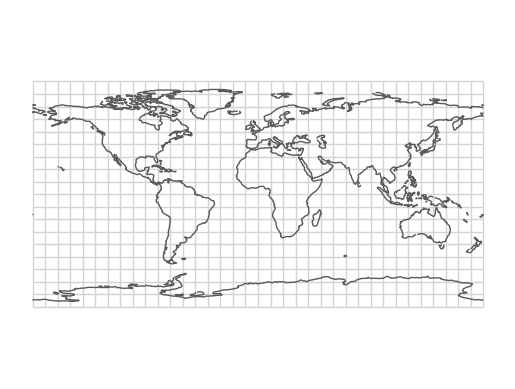

In [57]:
_, ax = plt.subplots()
plot_world(ax, raw_points, numgraticule, numline)
plt.show()

## Github modules

We actually have saved the `plot_world` function in a .py file in the `geom` module in a file called [plot_worldmap.py](https://github.com/gisalgs/geom/blob/master/plot_worldmap.py). To install the geom module, we can first delete it using the command `rm` and the redo `git clone` as follows:

In [58]:
!rm geom -rf
!git clone https://github.com/gisalgs/geom.git

Cloning into 'geom'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 354 (delta 17), reused 4 (delta 1), pack-reused 314 (from 1)
Receiving objects: 100% (354/354), 86.00 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [59]:
from geom.plot_worldmap import *

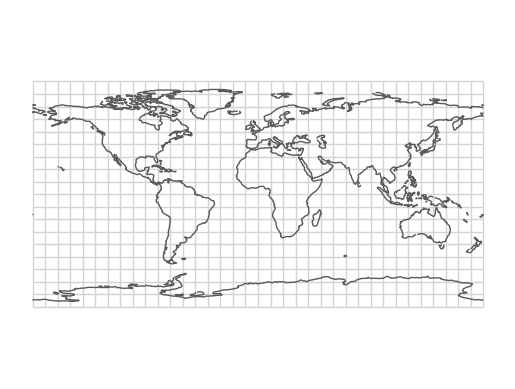

In [60]:
_, ax = plt.subplots(1, 1)
plot_world(ax, raw_points, numgraticule, numline)
plt.show()

## Equirectangular projection

The equirectangular projection can be formulated as follows:

$x = \lambda \cos(\varphi_0)$  
$y = \varphi$

where $\varphi_0$ is the standard latitude or standard parallel that determines the overall width of the projected map. The special case we just saw at the beginning of today's note can be obtained by simply setting $\varphi_0$ to 0 (the equator).

This all looks straightforward. But there is a caveat here. It should be noted that the lat/lon values we use are typically in **degrees** (as in 0 to 360 degrees for a full circle), but the trigonometric functions in Python will use **radians** (as in 0 to 2$\pi$) as the unit for angles, where 180 degree is equivalent to $\pi$. We will need to convert them, which can be done by importing the function called `radians` from the `math` module.

In [61]:
from math import sin, cos, radians, pi
print(sin(pi/2.0))
print(cos(pi/2.0))
print(pi)
print(radians(360))
print(radians(180))
print(radians(45))
print(cos(radians(90)))
print(cos(radians(360)))

1.0
6.123233995736766e-17
3.141592653589793
6.283185307179586
3.141592653589793
0.7853981633974483
6.123233995736766e-17
1.0


The Python code to make the above transformation for the equirectangular projection is listed below.

```python
def transform_equirectangular(lon, lat, lat0=0):
    x = lon * cos(radians(lat0))
    y = lat
    return x, y
```

The complete code of this is also stored at gisalgs Github in [transforms.py](https://github.com/gisalgs/geom/blob/master/transforms.py). This python file also contains another function that will soon be used. We will again download this and save it into our **geom** folder.

We can test this transformation function using the lon and lat of Columbus as an example.

In [62]:
from geom.transforms import transform_equirectangular
print(transform_equirectangular(-83, 40))

(-83.0, 40)


Now we project the original data (in `raw_points`) into a new projection. This has to be done point by point:

In [63]:
from geom.transforms import transform_equirectangular

points=[]
for p in raw_points:
    p1 = transform_equirectangular(p[1], p[2])
    points.append([p[0], p1[0], p1[1]])

Drawing the new points is simple. Note that we use `points` instead of `raw_points` below:

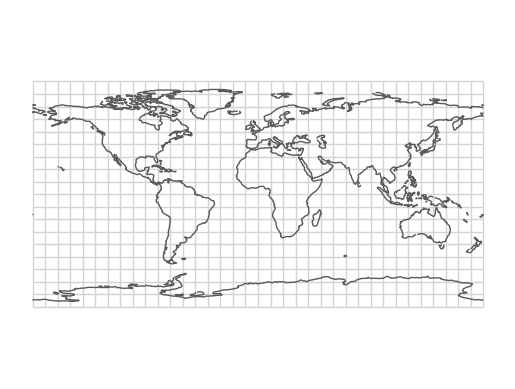

In [64]:
_, ax = plt.subplots(1, 1)
plot_world(ax, points, numgraticule, numline)
plt.show()

So this is what happens: the plotting of the "raw" data (i.e., lat/lon) looks exactly the same as the projected data. This shouldn't be a surprise: the projected coordinates are indeed as same as the raw data in the special case when $\phi_0$ is set to 0, which is the default value of the transformation function `transform_equirectangular`. Given how the projection looks, there is a good reason to call this **equirectangular** projection. The equirectangular projection apparently tends to **distort** the area, especially when we move always from the standard parallels. It should be noted that the equirectangular projection does not always produce squires as shown above (see questions below for more detail).


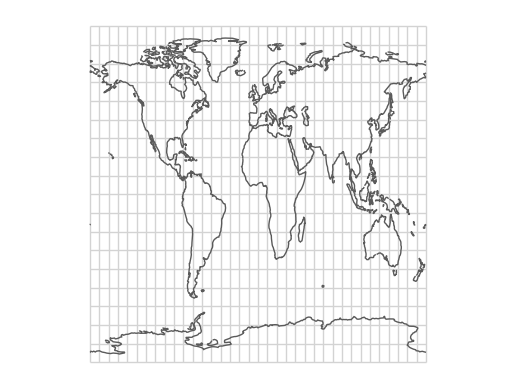

In [65]:
# TODO:
#   Project the world map using the transform_equirectangular function where lat0 is set to 60.
#   code here:
from geom.transforms import transform_equirectangular

points2=[]
for p in raw_points:
    p1 = transform_equirectangular(p[1], p[2], 60)
    points2.append([p[0], p1[0], p1[1]])

_, ax = plt.subplots(1, 1)
plot_world(ax, points2, numgraticule, numline)
plt.show()

In [66]:
# TODO
#    explain below why the above map is only a half of the width as when `lat0` is the default value?
#    You can use write your explanation below in the docstring:

# Since lat0 is the standard latitude/parallel and it is changed to 60, the width of the projection will change. This is because the equation for this projection is(longitude)(cos(lat0)) and if lat0 is changed then the projection
# will be more or less wide than when it is set to the equator at 0.




## Sinusoidal projection

There are projections that do not distort size and the [**sinusoidal** projection](https://en.wikipedia.org/wiki/Sinusoidal_projection) is one of them. The equations for the sinusoidal projection are also simple:

$x = (\lambda - \lambda_0) \cos(\varphi)$<br/>
$y = \varphi$

where $\lambda_0$ is central meridian. Because the use of $\cos(\varphi)$, the length of parallels will become zero when $\varphi$ reaches 90 (poles), which forces the convergence of the meridians and therefore preserve the area. Here is the Python function that does the transformation:

```python
def transform_sinusoidal(lon, lat, lon0=0):
    lon1 = lon-lon0
    x = lon1 * cos(radians(lat))
    y = lat
    return x, y
```

Now we follow a similar procedure as did in the previous project to draw the output. The following is the figure that illustrates the sinusoidal projection with prime meridian as the standard meridian.

In [67]:
from geom.transforms import transform_sinusoidal

points=[]

# TODO:
#   Use function transform_sinusoidal to project all points in raw_points
#   Append the projected points and their line ID's to list point
#   code here:

points3=[]
for p in raw_points:
    p1 = transform_sinusoidal(p[1], p[2])
    points3.append([p[0], p1[0], p1[1]])



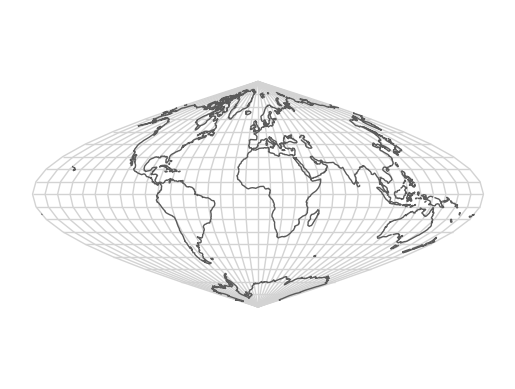

In [68]:
# TODO:
#    Draw world map in Sinusoidal projection
#    code here

_, ax = plt.subplots(1, 1)
plot_world(ax, points3, numgraticule, numline)
plt.show()


### Problems with central meridian

What happens if we set `lon0` to 60 using our code? It will yield a strange, asymmetrical map. Why? We are not going to answer this in class and this will be one of the questions in the second homework.

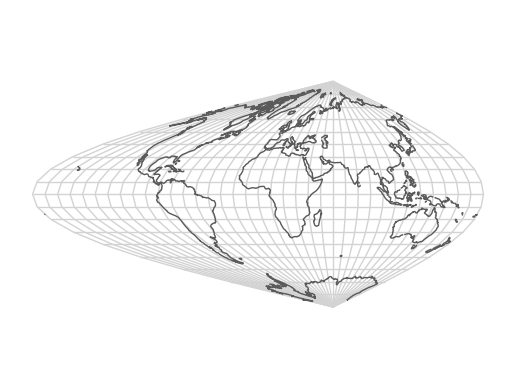

In [69]:
points1=[]
for p in raw_points:
    p1 = transform_sinusoidal(p[1], p[2], 60) # central meridian at 60
    points1.append([p[0], p1[0], p1[1]])

_, ax = plt.subplots(1, 1)
plot_world(ax, points1, numgraticule, numline)
plt.show()

### More on equal-area (Tissot's indicatrix)

So how do we know the the Sinusoidal projection is equal-area? There are a lot of signs we can tell. For example, we can examine how the graticule looks. There are patterns that an equal area projection should follow (as discussed in many cartography classes) and we can use those to make some educated conclusions. We can also use math to tell. For a project based on a sphere with a unit radius, an equal area projection will have the following property (Snyder 1987, p. 28):

$$
\frac{\partial x}{\partial \lambda} \frac{\partial y}{\partial \varphi} - \frac{\partial x}{\partial \varphi} \frac{\partial y}{\partial \lambda} = \cos\varphi
$$

where $\lambda$ is longitude and $\varphi$ is latitude.

For those who are comfortable with math, we can definitely conclude that the projection is indeed equal area. But what else? We can actually do some more visualization using a device called [Tissot's indicatrix](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix). The idea is to put some infinitely small circles of the same size (mathematically unit size) at different places on the globe and then see how they look after they are projected. The original tool is a mathematically tool (who else would be interested in circles that are infinitely small?), but we can definitely relax it a little bit by using some circles that are more legible. There is a GeoJSON file that contains some circles at our [github geom repo](https://github.com/gisalgs/data/blob/master/tissot.geojson) and we will see how to use it here.

In [70]:
url = 'https://raw.githubusercontent.com/gisalgs/data/master/tissot.geojson'
# TODO
#
#   Read the geojson file from the above url using
#   Load everything into a variable called tissots
#   Code here:

with request.urlopen(url) as response:
    tissots = json.loads(response.read())



Each circle is just a set of systematically generated points that are separated with the same distance on the circle:

In [71]:
len(tissots['features'][0]['geometry']['coordinates'][0])

121

We will first put the points on the circle in the same way as we treat the coastlines, but we will start from a new list:

In [72]:
tissots_raw_points = []

tline = 0
for f in tissots['features']:
    geom = f['geometry']['coordinates']
    for p in geom[0]:
        tissots_raw_points.append([tline, p[0], p[1]])
    tline += 1

tissots_points = []

for p in tissots_raw_points:
    p1 = transform_sinusoidal(p[1], p[2])
    tissots_points.append([p[0], p1[0], p1[1]])



The following code calls the `plot_world` function first and then add the new lines (circles) onto the same ax. This way, we can draw everything together in one map.We should see all the circles are rendered at relatively the same size, an indication of an equal area projection.

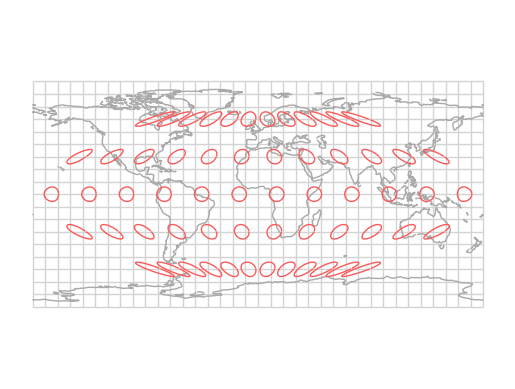

In [87]:
_, ax = plt.subplots(1, 1)
plot_world(ax, raw_points, numgraticule, numline, 'darkgrey')

for i in range(tline):
    col = '#fa5a5a'
    pts = [[p[1], p[2]] for p in tissots_points if p[0]==i]
    l = plt.Polygon(pts, color=col, fill=False, closed=False)
    ax.add_patch(l)

plt.show()

If we have some hard time to tell whether the sizes are the same (the are very close though), we can actually calculate the sizes using what we have learned before and print out the sizes. We just need to import a couple of modules first:

In [74]:
from geom.point import *
from geom.centroid import *

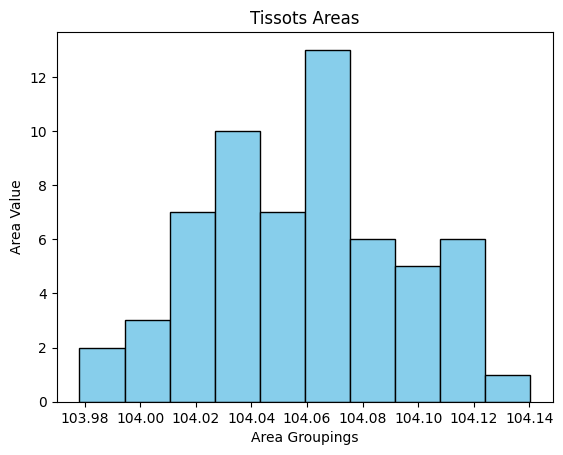

In [77]:
areas = []
for f in tissots['features']:
    polygon = []
    for p in f['geometry']['coordinates'][0]:
        p1 = transform_sinusoidal(p[0], p[1])
        polygon.append(Point(p1[0], p1[1]))
    area, _ = centroid(polygon)
    areas.append(area)

# TODO:
#   Draw the histogram of the areas of Tissot's indicatrix
plt.hist(areas, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Area Groupings')
plt.ylabel('Area Value')
plt.title('Tissots Areas')

plt.show()



So the numbers are not exactly the same, but they are awfully close. The reason for the slight differences is the circles are not small enough.

## Case study 1: making a toy (and bad) projection

Let's design a simple but interesting projection.

In [78]:
def transformx(lon, lat):
    x = lon*(90-lat)/90
    y = lat
    return x, y

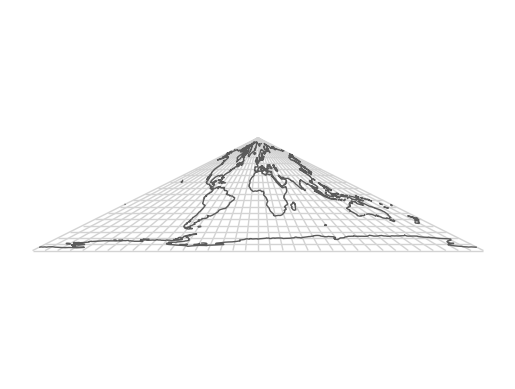

In [79]:
# TODO
#   show the world map using the projection implemented in function transformx
#   code here:

transform_points = []

for p in raw_points:
    p1 = transformx(p[1], p[2])
    transform_points.append([p[0], p1[0], p1[1]])

_, ax = plt.subplots(1, 1)
plot_world(ax, transform_points, numgraticule, numline)
plt.show()


This is very promising in the sense that we have got a project where all the meridian converge at one of the poles. Can we change the formula so that they converge to both poles so that the part of meridian in the southern hemisphere converge to the south pole?

In [82]:
# TODO
#    change (redefine) the transformx function below so that the meridians converge to both poles

def transformx(lon, lat):
    x = lon*(90-abs(lat))/90
    y = lat
    return x, y



In [84]:
# TODO
#   project raw_points using the new transformx function

transform_points = []

for p in raw_points:
    p1 = transformx(p[1], p[2])
    transform_points.append([p[0], p1[0], p1[1]])


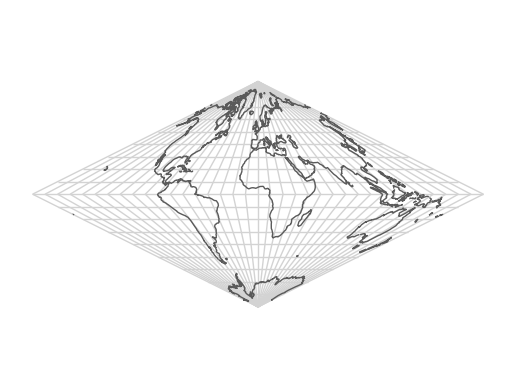

In [85]:
# TODO
#    Draw the world map using newly projected points

_, ax = plt.subplots(1, 1)
plot_world(ax, transform_points, numgraticule, numline)
plt.show()



Is this an equal area projection? We will once again use the Tissot's indicatrix to visually answer it.

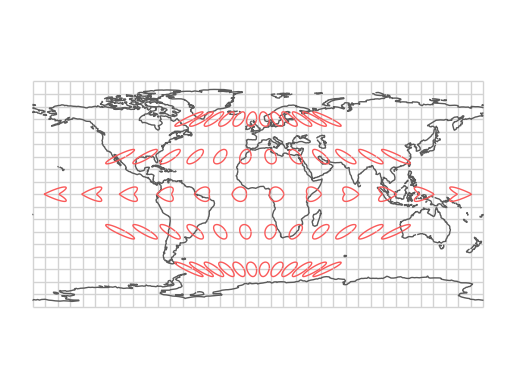

In [88]:
_, ax = plt.subplots(1, 1)
plot_world(ax, raw_points, numgraticule, numline)


tissots_points = []

for p in tissots_raw_points:
    p1 = transformx(p[1], p[2])
    tissots_points.append([p[0], p1[0], p1[1]])


for i in range(tline):
    col = '#fa5a5a'
    pts = [[p[1], p[2]] for p in tissots_points if p[0]==i]
    l = plt.Polygon(pts, color=col, fill=False, closed=False)
    ax.add_patch(l)

plt.show()

We should be able to see the transformed "circles" (they don't look like circles anymore) have different sizes. However, if we are not sure, we can always calculate the areas of all the transformed circles:

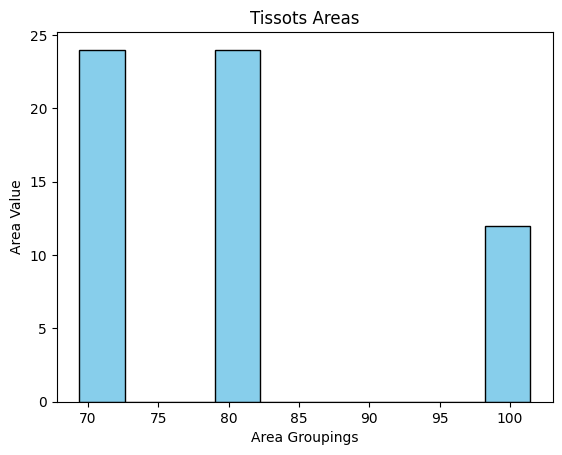

In [90]:
# TODO:
#   Calculate the areas of the circles projected using the new transformx function
#   Code here

areas = []
for f in tissots['features']:
    polygon = []
    for p in f['geometry']['coordinates'][0]:
        p1 = transformx(p[0], p[1])
        polygon.append(Point(p1[0], p1[1]))
    area, _ = centroid(polygon)
    areas.append(area)

plt.hist(areas, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Area Groupings')
plt.ylabel('Area Value')
plt.title('Tissots Areas')

plt.show()


## Case study 2: Equal-area revisited

Is the sinusoidal project truly preserving the area? How to compute the "real" area of a a shape? By real, we mean the size of the shape on earth surface. But we should also be cautious that whatever we calculate is based on a lot of assumptions, such as the model used to represent the earth. Here we assume a perfect sphere, which of course is not what the earth actually is.

Here, we are interested in the area of a quadrilateral that is formed by longitudes and latitudes as depicted in the following figure:

![](https://github.com/gisalgs/notebooks/blob/main/figures/quadarea.gif?raw=1)  
(Source: https://www.mathworks.com/help/map/ref/areaquad.html#bvk_mav)

In the above figure, the term quadrangle is used, but we will use a more commonly used term, quadrilateral (on a sphere). Mathematically, the area of a quadrilateral formed by two parallels at *a* and *b* (a<b) and two meridians that differ in *d* is calculated as:

$R^2 (\sin b - \sin a ) d$

where $R$ is the radius of the spherical earth, 6371 KM or 3959 miles. All angles are measured in radians. All the angular measures, *a*, *b*, and *d*, are in radians.

Here are some more sources for this topic:

- https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/
- https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html

For example, the quadrilateral between latitudes 0 and 10 bound by two meridians differing in 10 degrees has an area calculated as follows:

In [91]:
6371**2 * (sin(radians(10)) - sin(0)) * radians(10)

1230163.4172191652

Now, we create the same quadrilateral in longitudes and latitudes and then transform the points using the sinusoidal projection. The `transform_sinusoidal` assume the radius of the earth is 1. So we will find a way to make sure we get the "real-world" coordinates. Recall the equations for the sinusoidal project:

$x = \lambda \cos(\varphi_0)$  
$y = \varphi$

The value (as in the number) of the Y coordinate from this formula is as same as the latitude. Let's assume the earth is a perfect sphere with a radius or R. When we imagine the earth is flattened into a flat 2-dimensional space, the upper bound of the Y coordinate should be a half of the meridian, or a quarter of the equator. The circumference of the earth is $2 \pi R$, and therefore when the latitude $\varphi$ is 90, Y should be $\frac{1}{2} \pi R$. If latitude is measured in radians, then the north pole is $\frac{1}{2} \pi$ and its latitude, after transformed, is exactly $\frac{1}{2} \pi R$, which means if we multiply the earth radius with $\varphi$ (again, measured in radians). The same thing can be said for the longitude. So by simply scaling both the X and Y coordinates in the formula with the earth radius, we will get X and Y in "real-world" measures instead of just a generic number:

$x = R \lambda \cos(\varphi_0)$  
$y = R \varphi$

If the longitude and latitude are measured in degrees, then we will simply figure out the length of each degree on a great circle (such as the equator) and multiply that with the degree. Below we calculate the length of a degree in kilometer, but we can easy use the statute miles if needed.

In [92]:
# the size of the earth as a sphere with the same surface area of the ellipsoid
# radius = 3959 # miles
radius = 6371 # km
circumference = 2 * pi * radius
degreelength = circumference/360
degreelength

111.19492664455873

We should note that **111** is a number worth memorizing: it is the length of a degree in kilometer on the equator or any meridian. But the length of a degree longitude decreases from 111 to 0 when we go from the equator to the poles.

Now we get the quadrilateral and calculate the size. We calculate the size using our `centroid` function that computes the area of a closed polygon. It should be noted that the `transform_sinusoidal` doesn't consider the earth radius, nor the unit (radians or degree) of the coordinates. So it is our job to make sure we know the units and how to scale the coordinates. Below is an example of scaling the coordinates into kilometers.

In [93]:
qaudrilateral = [ [0, 0], [0, 10], [-10,10], [-10, 0], [0, 0] ]
qaudrilateral = [ Point(p[0], p[1]) for p in qaudrilateral ]

coordinates1 = [transform_sinusoidal(p[0], p[1]) for p in qaudrilateral]
coordinates1 = [Point(degreelength*p[0], degreelength*p[1]) for p in coordinates1]

centroid(coordinates1)

(1227039.0872811307, [-551.762156547702, 554.5561072666402])

We note this size is slightly smaller than what we got above using the math. In practice, if this is all the points we get, we will accept the result and acknowledge that the result may have problems because lines with certain curvature may have been generalized to straight lines.

However, let's push the envelope a little further here to develop some deep understanding of the nuances of spatial data -- let's call this the hardcore of spatial data science!

The slight difference we observed above is due to the fact that we treat the meridians as straight lines instead of curves. If we add one more point on each of the two meridians (`[0, 5]` and `[-10, 5]`), we are going to get a number that is closer to the true size:

In [94]:
qaudrilateral = [ [0, 0], [0, 5], [0, 10], [-10,10], [-10, 5], [-10, 0], [0, 0] ]
qaudrilateral = [ Point(p[0], p[1]) for p in qaudrilateral ]

coordinates1 = [transform_sinusoidal(p[0], p[1]) for p in qaudrilateral]
coordinates1 = [Point(degreelength*p[0], degreelength*p[1]) for p in coordinates1]

centroid(coordinates1)

(1229382.6322675063, [-552.8166059394334, 554.5588113713716])

If we continuously add more points, we will get closer and closer to the true curve and the area should be closer and closer to what we got using the formula (the true area if we assume a perfect sphere). To do this, we write a function to help us get a quadrilateral with the precision (increment of degree on the sides) we want:

In [95]:
def make_quadrilateral(lon, lat, length=10, increment=0.01):
    '''
    Create a quadrilateral using the lon and lat as the starting point at the lower-right corner (south-east).
    The polygon goes counterclockwise. Going north first then west then south then east back to the south-east corner.

    INPUT
        lon - the longitude of the south-east corner of the quad
        lat - the latitude
        length - the length, in degree, of the sides
        increment - the increment, in degree, of the points along the sides

    OUTPUT
        A list of Point objects. The last point is as same as the first.
    '''
    if lat+length > 90:
        raise Exception('lat+length>90')
    startss = [lat,        lon,        lat+length, lon-length] # the starting value of each side
    reaches = [lat+length, lon-length, lat,        lon]
    sameval = [lon,        lat+length, lon-length, lat] # the coordinate (lat or lon) keeps the same when along a side
    coords = []
    for i in range(4):
        v = startss[i]
        if i==0 or i==3:
            increment = abs(increment)
        else:
            increment = -abs(increment)
        num = abs(int(length/increment))
        for j in range(num):
        # while v != reaches[i]:
            # print(v)
            if i%2 == 0: # same lon
                coord = [sameval[i], v]
            else:        # same lat
                coord = [v, sameval[i]]
            coords.append(coord)
            v += increment
    coords.append([lon, lat])
    return coords

coords = make_quadrilateral(0, 0, 10, 5)
coords

[[0, 0],
 [0, 5],
 [0, 10],
 [-5, 10],
 [-10, 10],
 [-10, 5],
 [-10, 0],
 [-5, 0],
 [0, 0]]

For example, let's create a quadrilateral with increment of 0.01 and see what we get:

In [96]:
quad = [ Point(p[0], p[1]) for p in make_quadrilateral(0, 0, 10, 0.01) ]

quad = [transform_sinusoidal(p[0], p[1]) for p in quad]
quad = [Point(degreelength*p[0], degreelength*p[1]) for p in quad]

centroid(quad)

(1230163.4140964188, [-553.1677413396648, 554.5589911219304])

This should give us extremely close to we had before: 1230163.4172191652.

The following code shows us how our result approximates the "true" size when we increase the number of the points between the two ends on each side:

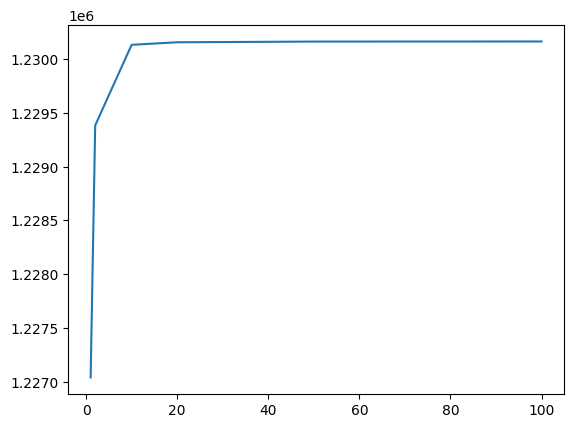

In [97]:
delta = [10, 5, 1, 0.5, 0.2, 0.1]

areas = []
for d in delta:
    quad = [ Point(p[0], p[1]) for p in make_quadrilateral(0, 0, 10, d) ]
    quad = [transform_sinusoidal(p[0], p[1]) for p in quad]
    quad = [Point(degreelength*p[0], degreelength*p[1]) for p in quad]
    a = centroid(quad)[0]
    areas.append(a)

# plot area vs. number of points on each side

ax, _ = plt.subplots()
plt.plot([10/d for d in delta], areas)
plt.show()

To wrap up, we should be confident that our projection functions do perform what they are supposed to. With an equal-area projection method, we are able to calculate the actual size of an area defined as a polygon.